In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

#@title Figure settings
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

# @title Plotting Functions

def plot_residual_histogram(res):
  """Helper function for Exercise 4A"""
  fig = plt.figure()

  plt.hist(res)
  plt.xlabel('error in linear model')
  plt.title('stdev of errors = {std:.4f}'.format(std=res.std()))

  plt.show()

def plot_training_fit(x1, x2, p):
  """Helper function for Exercise 4B"""
  fig = plt.figure()

  plt.scatter(x2 + np.random.standard_normal(len(x2))*0.02,
              np.dot(x1.T, p), alpha=0.2)
  plt.title('Training fit, order {r:d} AR model'.format(r=r))

  plt.xlabel('x')
  plt.ylabel('estimated x')
  plt.show()

# @title Helper Functions

def ddm(T, x0, xinfty, lam, sig):
  '''
  Samples a trajectory of a drift-diffusion model.

  args:
  T (integer): length of time of the trajectory
  x0 (float): position at time 0
  xinfty (float): equilibrium position
  lam (float): process param
  sig: standard deviation of the normal distribution

  returns:
  t (numpy array of floats): time steps from 0 to T sampled every 1 unit
  x (numpy array of floats): position at every time step
  '''
  t = np.arange(0, T, 1.)
  x = np.zeros_like(t)
  x[0] = x0

  for k in range(len(t)-1):
      x[k+1] = xinfty + lam * (x[k] - xinfty) + sig * np.random.standard_normal(size=1)

  return t, x

def build_time_delay_matrices(x, r):
    """
    Builds x1 and x2 for regression

    Args:
    x (numpy array of floats): data to be auto regressed
    r (scalar): order of Autoregression model

    Returns:
    (numpy array of floats) : to predict "x2"
    (numpy array of floats) : predictors of size [r,n-r], "x1"

    """
    # construct the time-delayed data matrices for order-r AR model
    x1 = np.ones(len(x)-r)
    x1 = np.vstack((x1, x[0:-r]))
    xprime = x
    for i in range(r-1):
        xprime = np.roll(xprime, -1)
        x1 = np.vstack((x1, xprime[0:-r]))

    x2 = x[r:]

    return x1, x2


def AR_prediction(x_test, p):
    """
    Returns the prediction for test data "x_test" with the regression
    coefficients p

    Args:
    x_test (numpy array of floats): test data to be predicted
    p (numpy array of floats): regression coefficients of size [r] after
    solving the autoregression (order r) problem on train data

    Returns:
    (numpy array of floats): Predictions for test data. +1 if positive and -1
    if negative.
    """
    x1, x2 = build_time_delay_matrices(x_test, len(p)-1)

    # Evaluating the AR_model function fit returns a number.
    # We take the sign (- or +) of this number as the model's guess.
    return np.sign(np.dot(x1.T, p))

def error_rate(x_test, p):
    """
    Returns the error of the Autoregression model. Error is the number of
    mismatched predictions divided by total number of test points.

    Args:
    x_test (numpy array of floats): data to be predicted
    p (numpy array of floats): regression coefficients of size [r] after
    solving the autoregression (order r) problem on train data

    Returns:
    (float): Error (percentage).
    """
    x1, x2 = build_time_delay_matrices(x_test, len(p)-1)

    return np.count_nonzero(x2 - AR_prediction(x_test, p)) / len(x2)

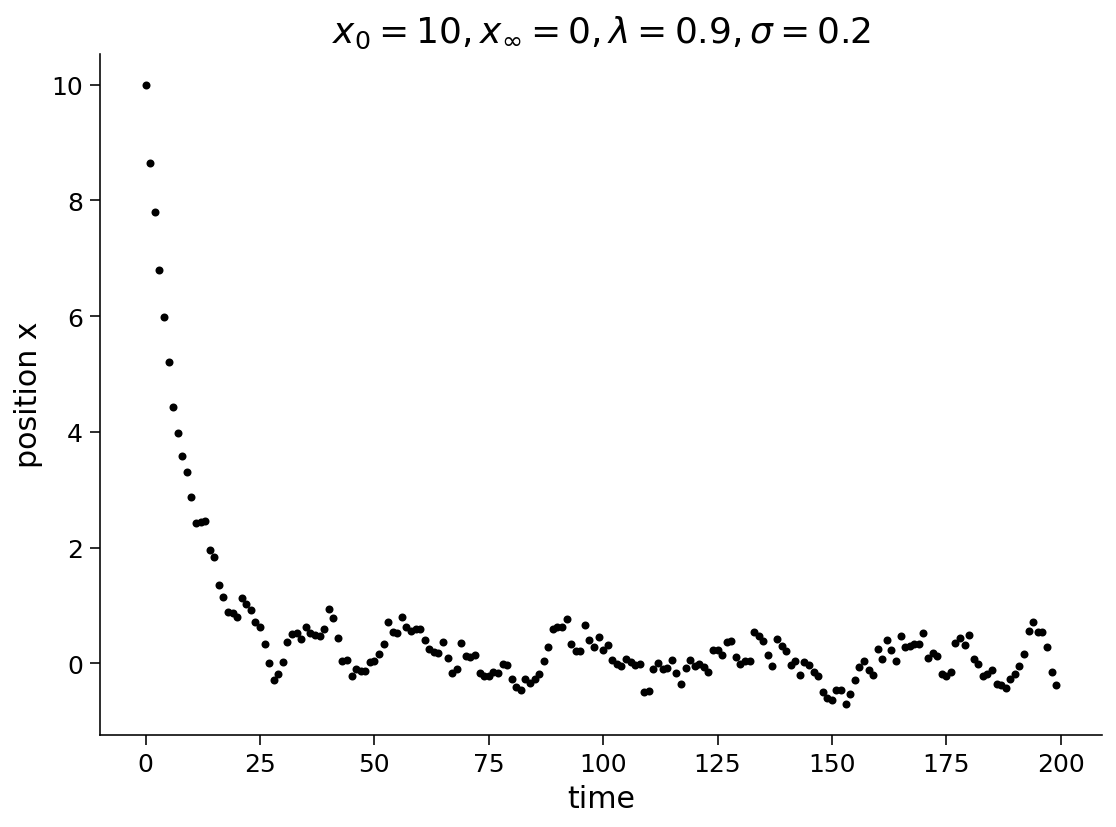

In [2]:
#@markdown Execute to simulate the drift diffusion model
np.random.seed(2020) # set random seed

# parameters
T = 200
x0 = 10
xinfty = 0
lam = 0.9
sig = 0.2

# drift-diffusion model from tutorial 3
t, x = ddm(T, x0, xinfty, lam, sig)

fig = plt.figure()
plt.title('$x_0=%d, x_{\infty}=%d, \lambda=%0.1f, \sigma=%0.1f$' % (x0, xinfty, lam, sig))
plt.plot(t, x, 'k.')
plt.xlabel('time')
plt.ylabel('position x')
plt.show()

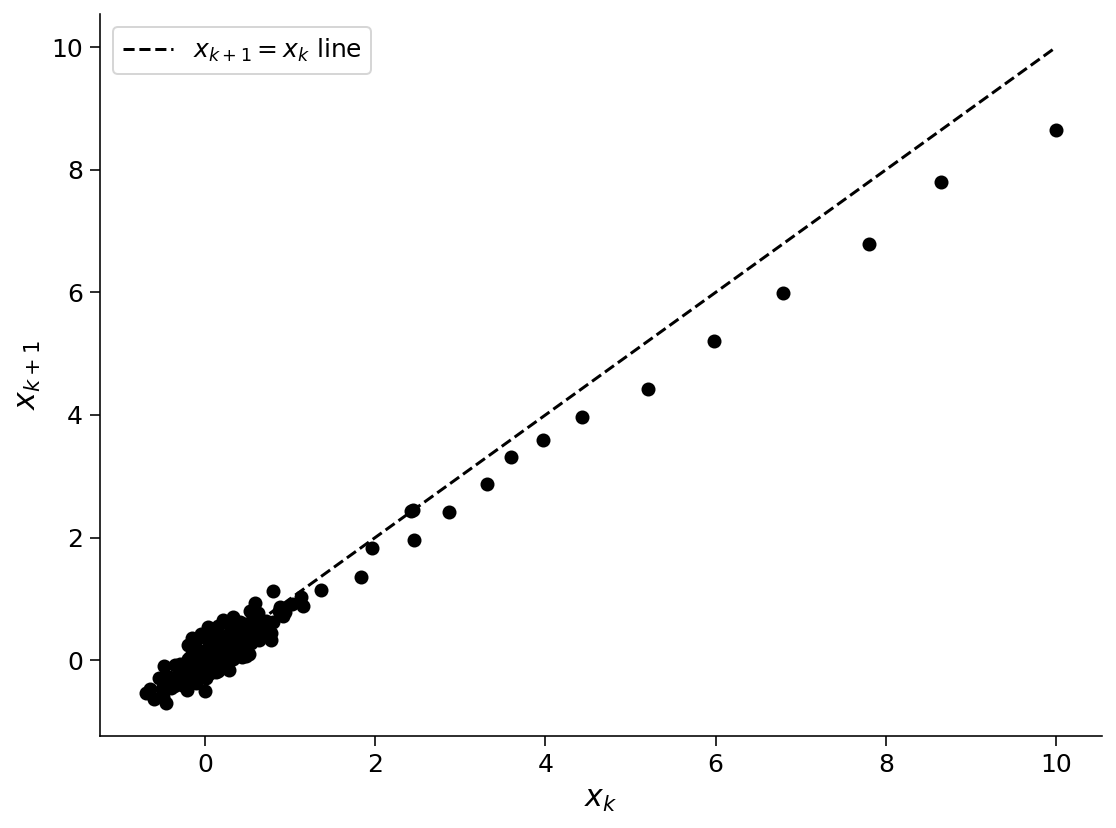

In [3]:
# @markdown Execute to visualize X(k) vs. X(k+1)
# make a scatter plot of every data point in x
# at time k versus time k+1
fig = plt.figure()
plt.scatter(x[0:-2], x[1:-1], color='k')
plt.plot([0, 10], [0, 10], 'k--', label='$x_{k+1} = x_k$ line')
plt.xlabel('$x_k$')
plt.ylabel('$x_{k+1}$')
plt.legend()
plt.show()

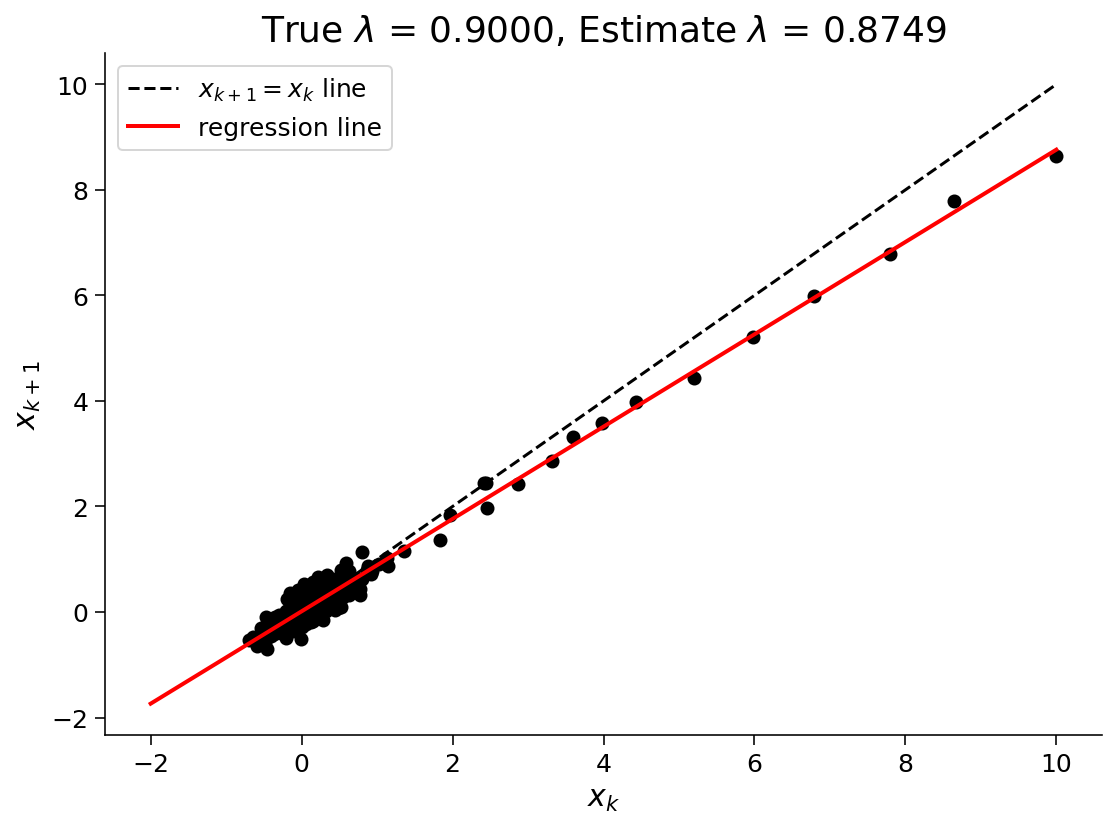

In [4]:
# @markdown Execute to solve for lambda through autoregression
# build the two data vectors from x
x1 = x[0:-2]
x1 = x1[:, np.newaxis]**[0, 1]

x2 = x[1:-1]

# solve for an estimate of lambda as a linear regression problem
p, res, rnk, s = np.linalg.lstsq(x1, x2, rcond=None)

# here we've artificially added a vector of 1's to the x1 array,
# so that our linear regression problem has an intercept term to fit.
# we expect this coefficient to be close to 0.
# the second coefficient in the regression is the linear term:
# that's the one we're after!
lam_hat = p[1]

# plot the data points
fig = plt.figure()
plt.scatter(x[0:-2], x[1:-1], color='k')
plt.xlabel('$x_k$')
plt.ylabel('$x_{k+1}$')

# plot the 45 degree line
plt.plot([0, 10], [0, 10], 'k--', label='$x_{k+1} = x_k$ line')


# plot the regression line on top
xx = np.linspace(-sig*10, max(x), 100)
yy = p[0] + lam_hat * xx
plt.plot(xx, yy, 'r', linewidth=2, label='regression line')

mytitle = 'True $\lambda$ = {lam:.4f}, Estimate $\lambda$ = {lam_hat:.4f}'
plt.title(mytitle.format(lam=lam, lam_hat=lam_hat))
plt.legend()
plt.show()

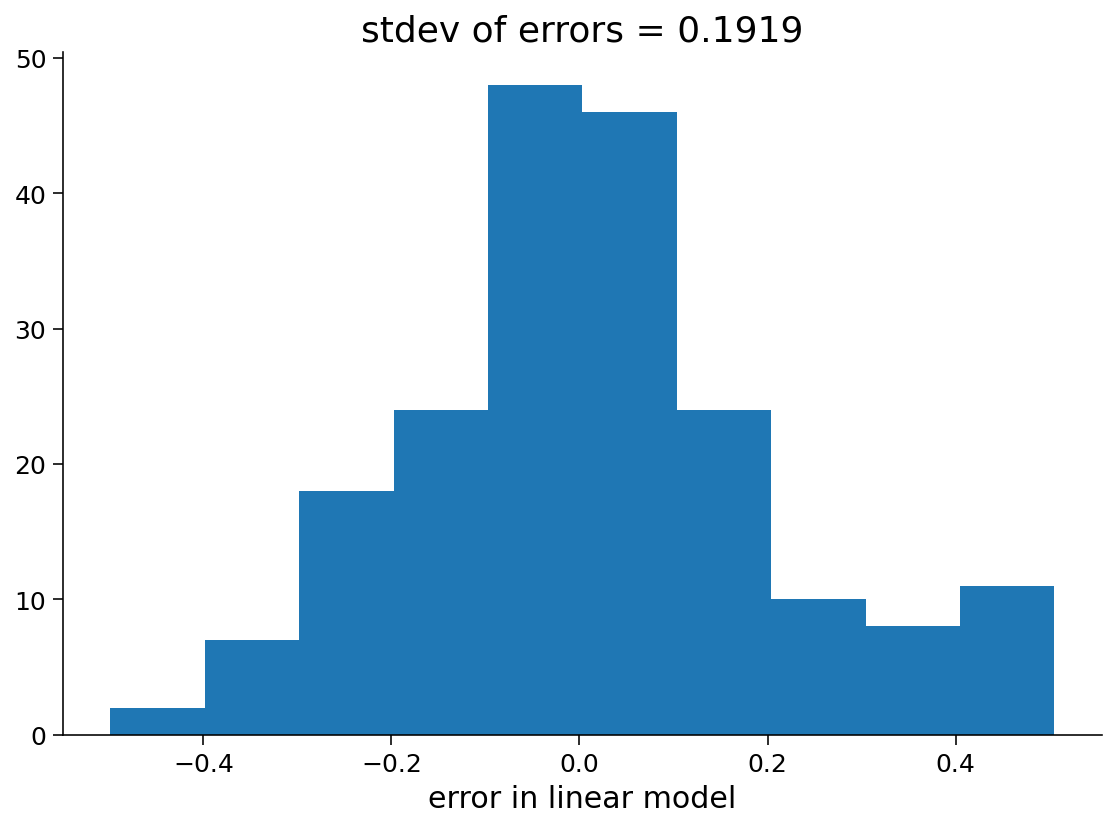

In [19]:
# compute the predicted values using the autoregressive model (lam_hat), and
# the residual is the difference between x2 and the prediction
res = x2 - (lam_hat *x1[:,1])

# Visualize
plot_residual_histogram(res)

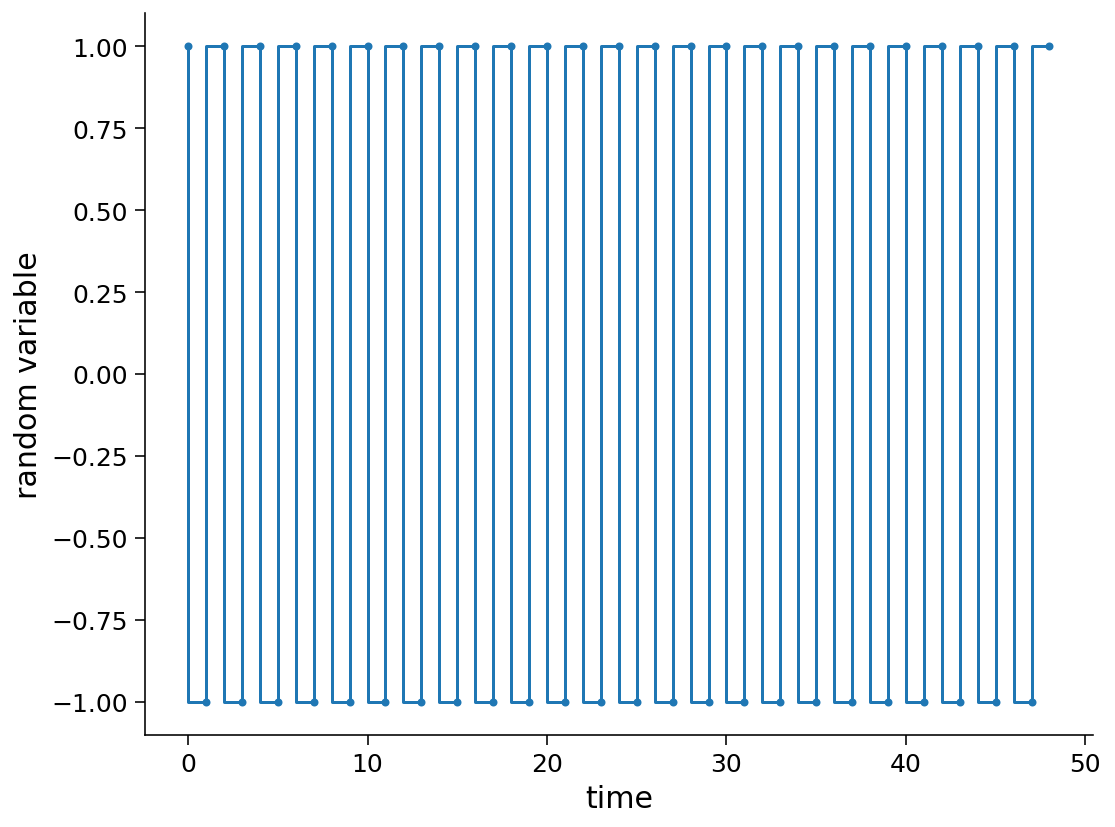

In [20]:
# this sequence is entirely predictable, so an AR model should work
monkey_at_typewriter = '1010101010101010101010101010101010101010101010101'

# Bonus: this sequence is also predictable, but does an order-1 AR model work?
#monkey_at_typewriter = '100100100100100100100100100100100100100'

# function to turn chars to numpy array,
# coding it this way makes the math easier
# '0' -> -1
# '1' -> +1
def char2array(s):
  m = [int(c) for c in s]
  x = np.array(m)
  return x*2 - 1

x = char2array(monkey_at_typewriter)

fig = plt.figure()
plt.step(x, '.-')
plt.xlabel('time')
plt.ylabel('random variable')
plt.show()

In [21]:
# build the two data vectors from x
x1 = x[0:-2]
x1 = x1[:, np.newaxis]**[0, 1]

x2 = x[1:-1]

# solve for an estimate of lambda as a linear regression problem
p, res, rnk, s = np.linalg.lstsq(x1, x2, rcond=None)

In [22]:
# take a look at the resulting regression coefficients
print('alpha_0 = {a0:.2f}, alpha_1 = {a1:.2f}'.format(a0=p[0], a1=p[1]))

alpha_0 = -0.00, alpha_1 = -1.00


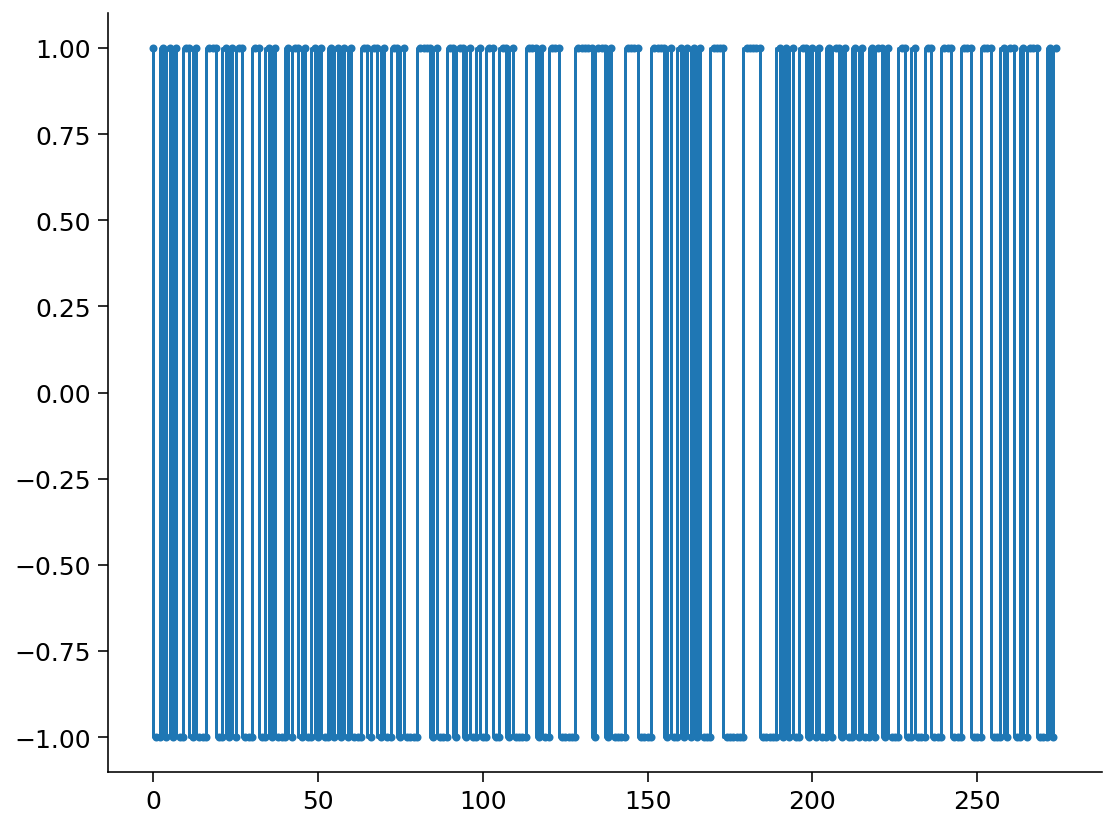

In [23]:
# data generated by 9-yr-old JAB:
# we will be using this sequence to train the data
monkey_at_typewriter = '10010101001101000111001010110001100101000101101001010010101010001101101001101000011110100011011010010011001101000011101001110000011111011101000011110000111101001010101000111100000011111000001010100110101001011010010100101101000110010001100011100011100011100010110010111000101'

# we will be using this sequence to test the data
test_monkey = '00100101100001101001100111100101011100101011101001010101000010110101001010100011110'

x = char2array(monkey_at_typewriter)
test = char2array(test_monkey)

## testing: machine generated randint should be entirely unpredictable
## uncomment the lines below to try random numbers instead
# np.random.seed(2020) # set random seed
# x = char2array(np.random.randint(2, size=500))
# test = char2array(np.random.randint(2, size=500))

fig = plt.figure()
plt.step(x, '.-')
plt.show()

In [24]:
# @markdown Execute this cell to get helper function `AR_model`

def AR_model(x, r):
    """
    Solves Autoregression problem of order (r) for x

    Args:
    x (numpy array of floats): data to be auto regressed
    r (scalar): order of Autoregression model

    Returns:
    (numpy array of floats) : to predict "x2"
    (numpy array of floats) : predictors of size [r,n-r], "x1"
    (numpy array of floats): coefficients of length [r] for prediction after
    solving the regression problem "p"
    """
    x1, x2 = build_time_delay_matrices(x, r)

    # solve for an estimate of lambda as a linear regression problem
    p, res, rnk, s = np.linalg.lstsq(x1.T, x2, rcond=None)

    return x1, x2, p

help(AR_model)

Help on function AR_model in module __main__:

AR_model(x, r)
    Solves Autoregression problem of order (r) for x
    
    Args:
    x (numpy array of floats): data to be auto regressed
    r (scalar): order of Autoregression model
    
    Returns:
    (numpy array of floats) : to predict "x2"
    (numpy array of floats) : predictors of size [r,n-r], "x1"
    (numpy array of floats): coefficients of length [r] for prediction after
    solving the regression problem "p"



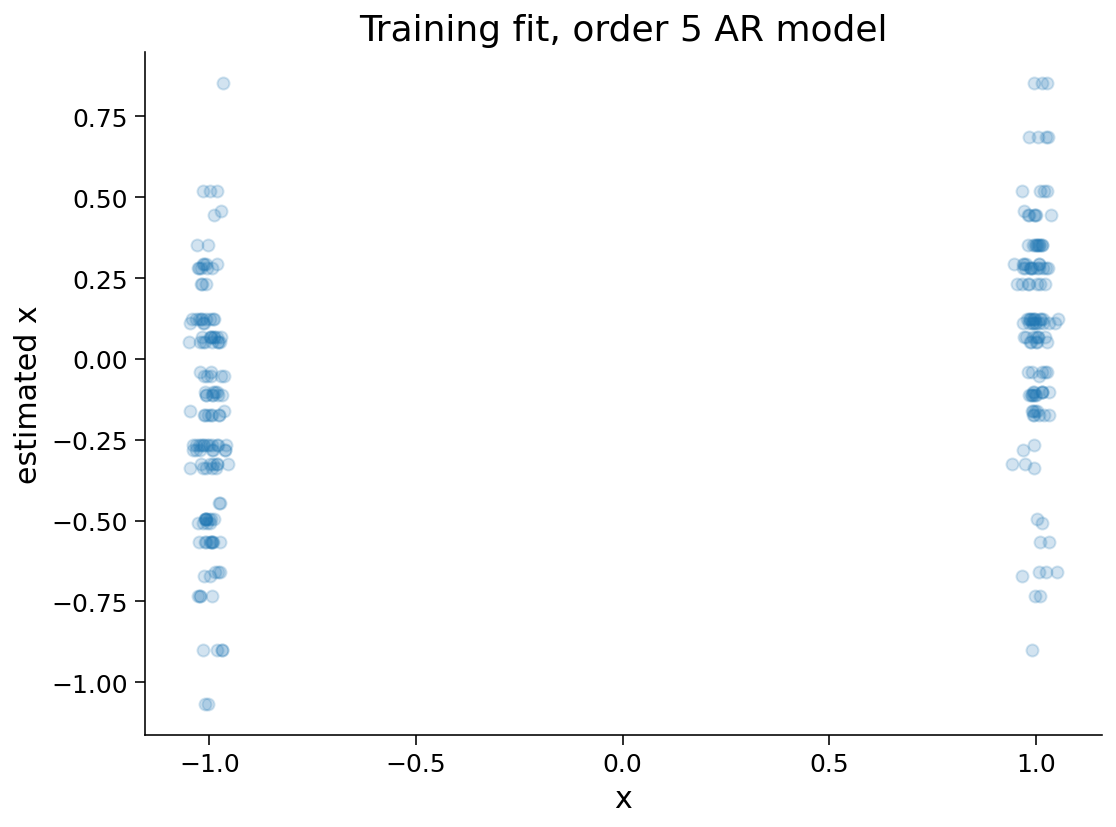

In [25]:

# define the model order, and use AR_model() to generate the model and prediction
r = 5
x1, x2, p = AR_model(x,5)

# Plot the Training data fit
# Note that this adds a small amount of jitter to horizontal axis for visualization purposes
plot_training_fit(x1, x2, p)

Text(0, 0.5, 'estimated x')

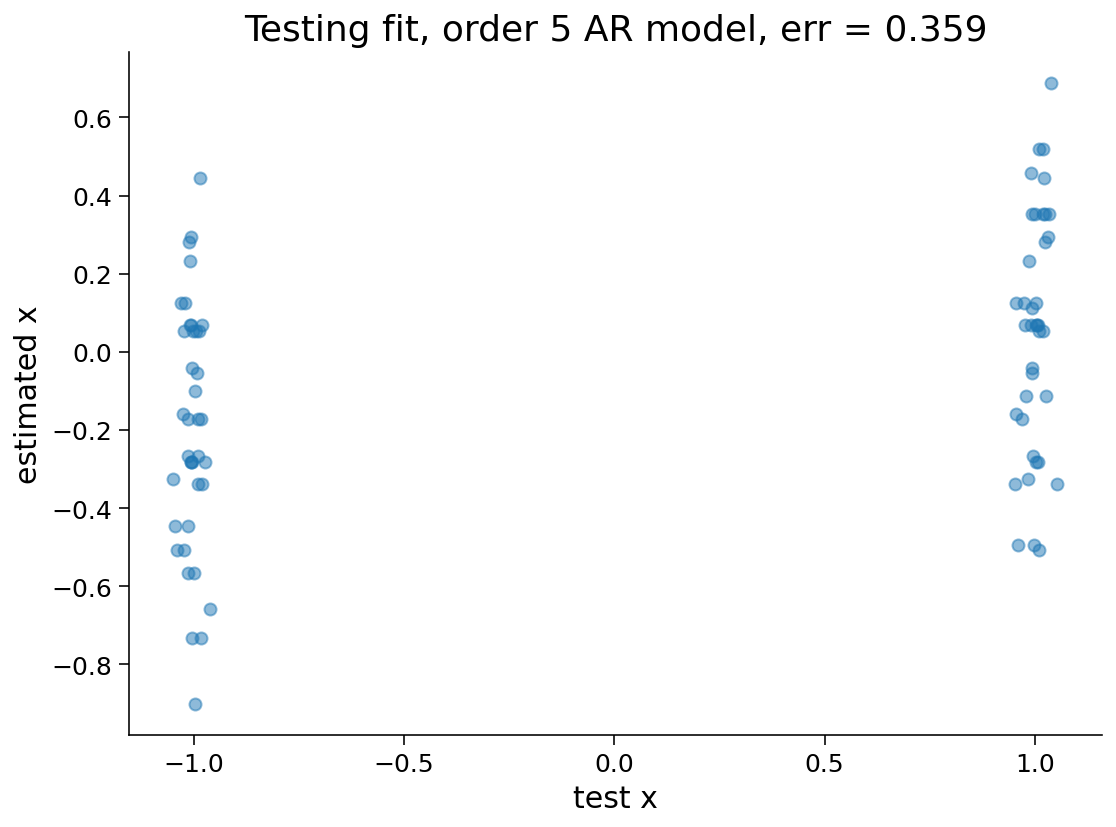

In [26]:
# @markdown Execute to see model performance on test data

x1_test, x2_test = build_time_delay_matrices(test, r)
fig = plt.figure()
plt.scatter(x2_test+np.random.standard_normal(len(x2_test))*0.02,
            np.dot(x1_test.T, p), alpha=0.5)

mytitle = 'Testing fit, order {r:d} AR model, err = {err:.3f}'
plt.title(mytitle.format(r=r, err=error_rate(test, p)))

plt.xlabel('test x')
plt.ylabel('estimated x')

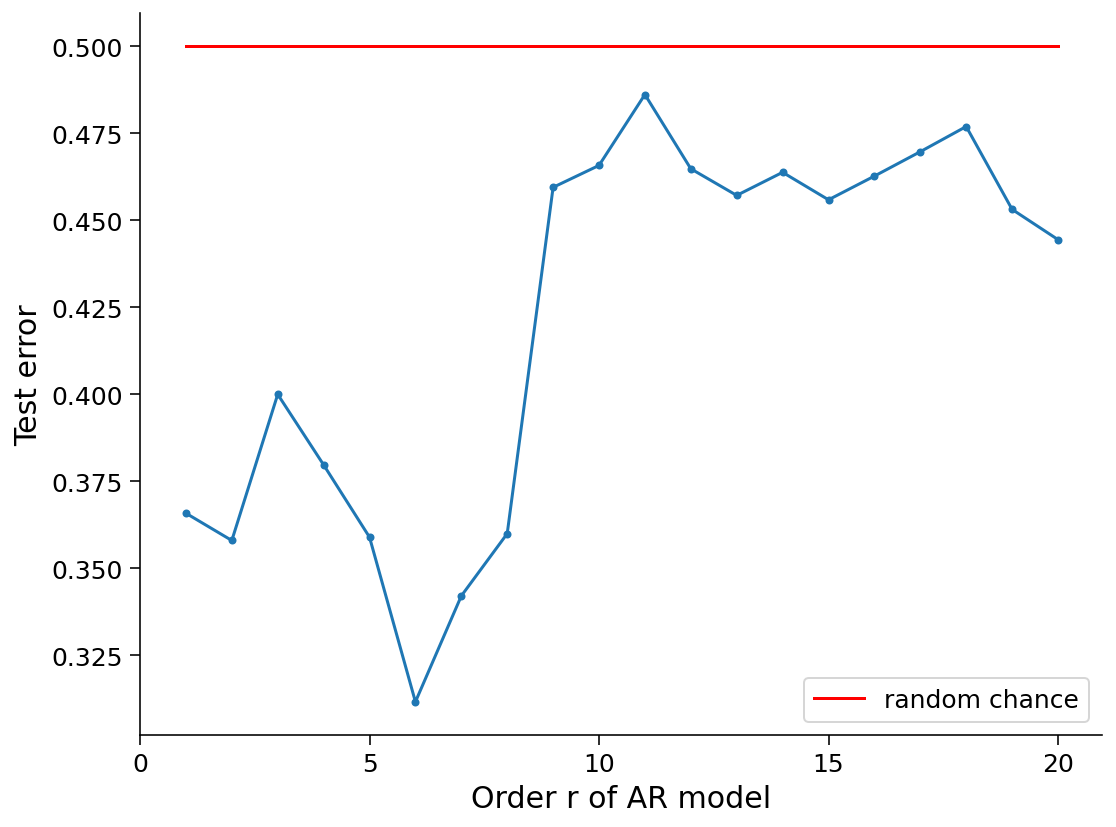

In [27]:
# @markdown Execute to visualize errors for different orders

# range of r's to try
r = np.arange(1, 21)
err = np.ones_like(r) * 1.0

for i, rr in enumerate(r):
    # fitting the model on training data
    x1, x2, p = AR_model(x, rr)
    # computing and storing the test error
    test_error = error_rate(test, p)
    err[i] = test_error

fig = plt.figure()
plt.plot(r, err, '.-')
plt.plot([1, r[-1]], [0.5, 0.5], c='r', label='random chance')
plt.xlabel('Order r of AR model')
plt.ylabel('Test error')
plt.xticks(np.arange(0,25,5))
plt.legend()
plt.show()